In [1]:
import re
import csv
import string
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.utils 
 
df = pd.read_csv('data/Shakespeare_data.csv')
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [2]:
print("Number of PlayerLines:", len(df['PlayerLine']))
print("First Few PlayerLines:")
print(df['PlayerLine'].head())

Number of PlayerLines: 111396
First Few PlayerLines:
0                                                ACT I
1                         SCENE I. London. The palace.
2    Enter KING HENRY, LORD JOHN OF LANCASTER, the ...
3               So shaken as we are, so wan with care,
4           Find we a time for frighted peace to pant,
Name: PlayerLine, dtype: object


In [3]:
print("\nText Length Statistics:")
print(df['PlayerLine'].apply(len).describe())


Text Length Statistics:
count    111396.000000
mean         38.196093
std          13.407790
min           1.000000
25%          34.000000
50%          41.000000
75%          46.000000
max        1029.000000
Name: PlayerLine, dtype: float64


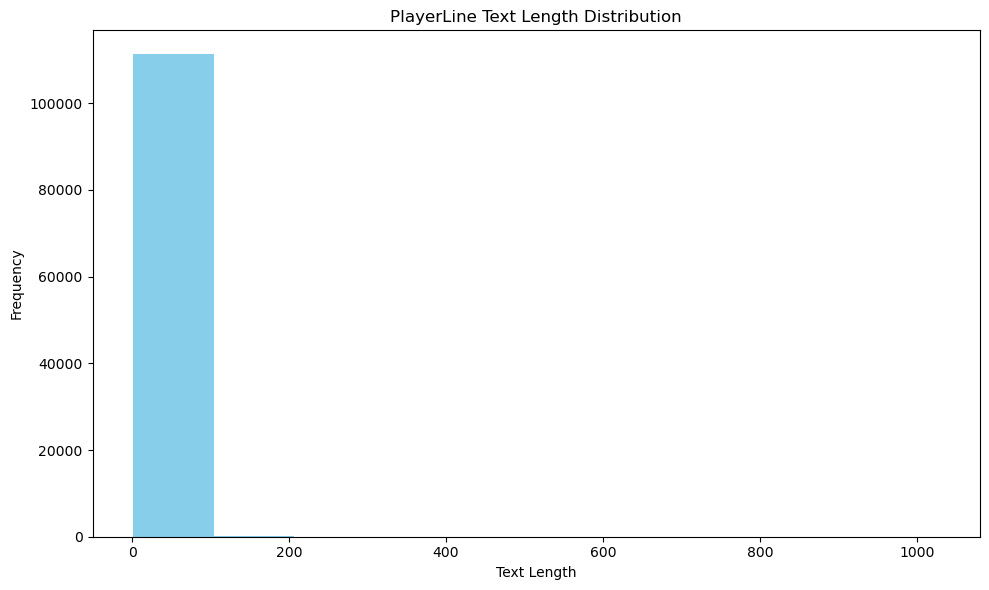

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(df['PlayerLine'].apply(len), bins=10, color='skyblue')
plt.title('PlayerLine Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
 
plt.tight_layout()
plt.show()

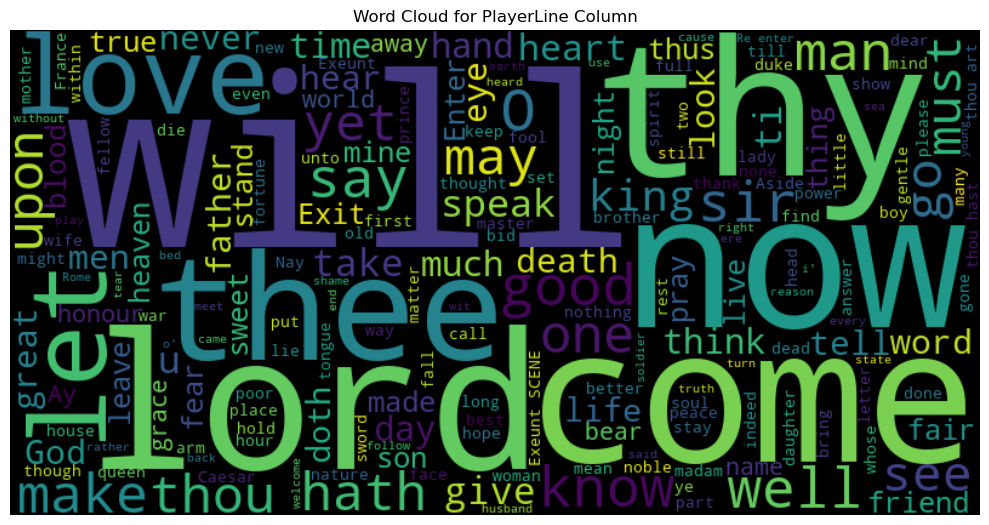

In [5]:
text = ' '.join(df['PlayerLine'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for PlayerLine Column')
plt.tight_layout()
plt.show()

In [6]:
corpus = []
with open('data/Shakespeare_data.csv') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)        
    for row in reader:
        corpus.append(row[5])
        
print(len(corpus))
print(corpus[:3])

111396
['ACT I', 'SCENE I. London. The palace.', 'Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others']


In [7]:
def text_cleaner(text):
    text = re.sub(r'\s+\n+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\.]', ' ', text)
    text = "".join(car for car in text if car not in string.punctuation).lower()
    text = text.encode("utf8").decode("ascii",'ignore')
    return text
 
corpus = [text_cleaner(line) for line in corpus]

In [8]:
corpus = corpus[:5000]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_words = len(word_index) + 1
total_words

5112

In [9]:
input_sequences =[]
 
for sentence in corpus:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
len(input_sequences)

33905

In [10]:
max_sequence_len = max([len(x) for x in input_sequences])
print(max_sequence_len)

34


In [11]:
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, 
                                         padding='pre'))
before = input_sequences[1]
after = input_sequences[1]

In [12]:
print(f'Before: {before}')
print(f'After: {after}')

Before: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 159   3]
After: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 159   3]


In [13]:
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = tensorflow.keras.utils.to_categorical(label, num_classes=total_words)
print(label[0])
print(label[0].shape)

[0. 0. 0. ... 0. 0. 0.]
(5112,)


In [14]:
glove_path = "data/glove.twitter.27B.200d.txt"
embeddings_index = dict()
with open(glove_path,
          encoding="utf8") as glove:
    for line in glove:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    glove.close()
 
embedding_matrix = np.zeros((total_words, 200))
for word, index in tokenizer.word_index.items():
    if index > total_words - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [15]:
model = Sequential()
model.add(Embedding(total_words, 200, 
                     weights = [embedding_matrix],
                     input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.3))
model.add(Dense(total_words, 
                activation='softmax'))
print(model.summary())

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,022,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,400 (3.90 MB)

 Trainable params: 1,022,400 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
class MyCallback(tf.keras.callbacks.Callback):
    
    def __init__(self,x,y):
        self.x=x
        self.y=y
 
    def on_epoch_end(self,batch, logs=None):    
        print("\nEpochs Ending Custom Callbacks:Intiation Predicting on test set:::")
        logs['from custom callback']=self.model.evaluate(self.x,self.y)[0]
def scheduler(epoch, lr):
 
    if epoch %2 == 0 :
        print("Epoch:",epoch,"Learning Rate:",lr)
        return lr
    else:
        print("Epoch:",epoch,"Learning Rate:", lr * tf.math.exp(-0.1))
        lr_updated= float(lr * tf.math.exp(-0.1))
        return  lr_updated
 
filename = "log_callbackscsvlogger.csv"
monitor_metric = "loss"
file_path = 'keras/model.{epoch:02d}-{loss:.2f}.keras'
 
my_callbacks = [
    MyCallback(predictors, label),
    tf.keras.callbacks.EarlyStopping(monitor=monitor_metric, min_delta=0, patience=5, verbose=0, mode="min", baseline=None, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor_metric, save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir="./tensorboardlogs"),
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0),
    tf.keras.callbacks.LambdaCallback(on_epoch_begin=lambda epoch, logs: print("Lambdacallback in epoch begin:: Epoch count", epoch))
]

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(predictors, 
                    label,
                    epochs=100,
                    batch_size=64,
                    verbose=1,
                    callbacks=my_callbacks)

Epoch: 0 Learning Rate: 0.0010000000474974513
Lambdacallback in epoch begin:: Epoch count 0
Epoch 1/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.0446 - loss: 6.8513
Epochs Ending Custom Callbacks:Intiation Predicting on test set:::
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.0979 - loss: 5.8690
530/530 ━━━━━━━━━━━━━━━━━━━━ 108s 201ms/step - accuracy: 0.0446 - loss: 6.8507 - from custom callback: 5.8920 - learning_rate: 0.0010
Epoch: 1 Learning Rate: tf.Tensor(0.00090483745, shape=(), dtype=float32)
Lambdacallback in epoch begin:: Epoch count 1
Epoch 2/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.0952 - loss: 5.8425
Epochs Ending Custom Callbacks:Intiation Predicting on test set:::
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.1310 - loss: 5.1942
530/530 ━━━━━━━━━━━━━━━━━━━━ 106s 200ms/step - accuracy: 0.0952 - loss: 5.8425 - from custom callback: 5.2174 - learning_rate: 9.0484e-04
Epoch: 2 Learning Rate: 0.0009048374486155808


In [19]:
model.save('results/shakespeare_model.h5')

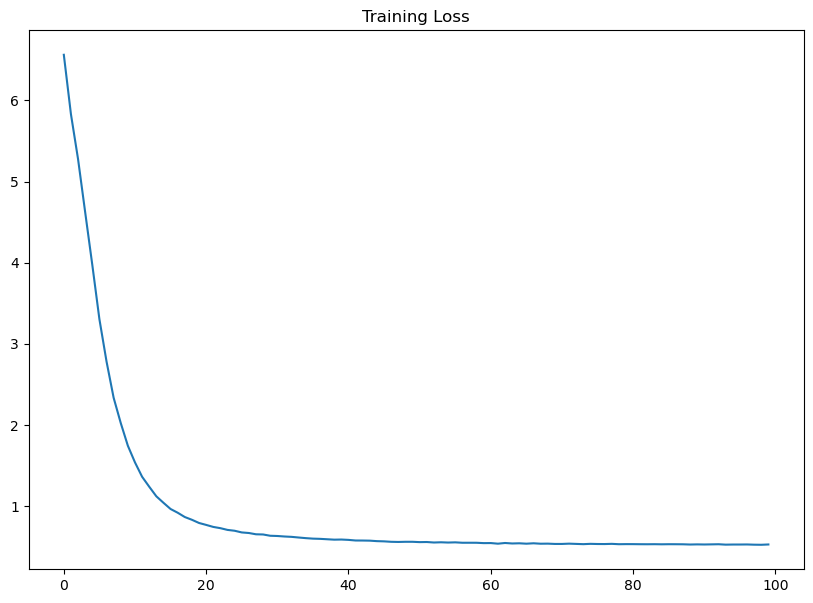

In [20]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'],label='Training Loss')
plt.title("Training Loss")
plt.show()

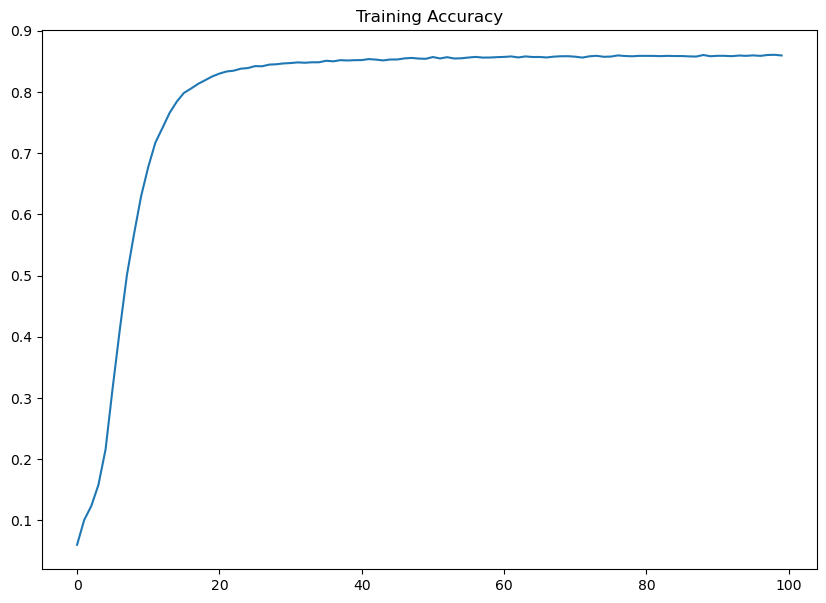

In [21]:
plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.title("Training Accuracy")
plt.show()

In [22]:
def greedy_search_generator(seed_text, num):
    if len(seed_text) == 0:
        print("Error: No word found")
        return
 
    for _ in range(num):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
        predicted = model.predict(token_list, verbose=0)
 
        predicted_word_index = np.argmax(predicted)
        predicted_word = tokenizer.index_word[predicted_word_index]
 
        seed_text += " " + predicted_word
 
    print(seed_text)
 
greedy_search_generator("my gentle cousin Westmoreland", 10)

my gentle cousin Westmoreland and was both in the morning early and to the


In [23]:
def beam_search_generator(seed_text, num_words, beam_width=3):
    if len(seed_text) == 0:
        print("Error: No word found")
        return
 
    input_sequence = tokenizer.texts_to_sequences([seed_text])[0]
    input_sequence = pad_sequences([input_sequence], maxlen=max_sequence_len - 1, padding="pre")
 
    sequences = [{'text': seed_text, 'sequence': input_sequence, 'score': 1.0}]
 
    for _ in range(num_words):
        next_candidates = []
        for candidate in sequences:
            input_sequence = candidate['sequence']
            predicted_probabilities = model.predict(input_sequence, verbose=0)
            top_words = np.argsort(predicted_probabilities[0])[-beam_width:]
 
            for word in top_words:
                if word != 0:
                    new_sequence = input_sequence.copy()
                    new_sequence[0][-1] = word
                    generated_word = tokenizer.index_word[word]
                    new_text = candidate['text'] + " " + generated_word
                    new_score = candidate['score'] * predicted_probabilities[0][word]
                    next_candidates.append({'text': new_text, 'sequence': new_sequence, 'score': new_score})
 
        next_candidates.sort(key=lambda x: -x['score'])
        sequences = next_candidates[:beam_width]
 
    for candidate in sequences:
        print(candidate['text'])
 
beam_search_generator("my gentle cousin Westmoreland", num_words=10, beam_width=3)

my gentle cousin Westmoreland and glendower and glendower and glendower and glendower and glendower
my gentle cousin Westmoreland and westmoreland and glendower and glendower and glendower and glendower
my gentle cousin Westmoreland and glendower and westmoreland and glendower and glendower and glendower


In [24]:
def random_sampling_generator(seed_text, num_words):
    generated_text = seed_text
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
        predicted = model.predict(token_list, verbose=0)
 
        predicted_word_index = np.random.choice(len(predicted[0]), p=predicted[0])
        predicted_word = tokenizer.index_word[predicted_word_index]
 
        seed_text += " " + predicted_word
        generated_text += " " + predicted_word
 
    return generated_text
 
generated_text_random = random_sampling_generator("my gentle cousin Westmoreland", num_words=10)
print(generated_text_random)

my gentle cousin Westmoreland and both being was but in the very gone and


In [25]:
def generate_text_random(seed_text, num_words, temperature):
    generated_text = seed_text
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
        predicted = model.predict(token_list, verbose=0)
 
        predicted = np.log(predicted) / temperature
        predicted = np.exp(predicted) / np.sum(np.exp(predicted))
 
        predicted_word_index = np.random.choice(len(predicted[0]), p=predicted[0])
        predicted_word = tokenizer.index_word[predicted_word_index]
 
        seed_text += " " + predicted_word
        generated_text += " " + predicted_word
 
    return generated_text
 
generated_text_random = generate_text_random("my gentle cousin Westmoreland", num_words=10, temperature=0.7)
print(generated_text_random)

my gentle cousin Westmoreland and will you with him and to my crown from


In [26]:
def top_k_sampling(logits, k=10):
    values, indices = tf.math.top_k(logits, k)
    values /= tf.reduce_sum(values)
    chosen_index = tf.random.categorical(tf.math.log(values), 1)[0, 0]
    return indices[0, chosen_index].numpy()
 
def generate_text_top_k(seed_text, num_words, k=10):
    generated_text = seed_text
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
        predicted = model.predict(token_list, verbose=0)
 
        predicted_word_index = top_k_sampling(predicted, k)
        predicted_word = tokenizer.index_word[predicted_word_index]
 
        seed_text += " " + predicted_word
        generated_text += " " + predicted_word
 
    return generated_text
 
generated_text_top_k = generate_text_top_k("my gentle cousin Westmoreland", num_words=10, k=10)
print(generated_text_top_k)

my gentle cousin Westmoreland and both of your men tell me your father and


In [27]:
def nucleus_sampling(logits, p=0.9):
    sorted_logits, sorted_indices = tf.math.top_k(logits, len(logits))
    cumulative_probs = tf.cumsum(tf.math.softmax(sorted_logits, axis=-1))
    sorted_indices_to_remove = cumulative_probs > p
 
    indices_to_remove = tf.range(0, len(logits)) > tf.reduce_sum(tf.cast(sorted_indices_to_remove, tf.int32))
 
    filtered_logits = logits - tf.reduce_max(logits)
    filtered_logits = tf.where(indices_to_remove, -np.inf, filtered_logits)
    sampled_word_index = tf.argmax(filtered_logits)
    return sampled_word_index
 
reverse_word_index = {value: key for key, value in tokenizer.word_index.items()}
 
def generate_text_nucleus(seed_text, num_words, p=0.9):
    generated_text = seed_text
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
        predicted = model.predict(token_list, verbose=0)
 
        predicted_word_index = int(nucleus_sampling(predicted[0], p))
        predicted_word = reverse_word_index[predicted_word_index]
 
        seed_text += " " + predicted_word
        generated_text += " " + predicted_word
 
    return generated_text
 
generated_text_nucleus = generate_text_nucleus("They lost", num_words=20, p=0.9)
print(generated_text_nucleus)

They lost the already of their own let it hear a son dare not a woman of me in the court of


In [28]:
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)